# **Importing Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from tqdm import tqdm

# **The KCGWO Class**

In [ ]:
class KCGWO:
  def __init__(self, objective_function, dim, search_domain, pop_size=30, max_iter=100):
        """
        Initialize the K-means Clustering based Grey Wolf Optimizer

        Parameters:
        - objective_function: the function to be minimized
        - dim: dimensionality of the search space
        - search_domain: tuple (min_val, max_val) for the search domain
        - pop_size: number of wolves in the pack
        - max_iter: maximum number of iterations
        """
        self.objective_function = objective_function
        self.dim = dim
        self.search_domain = search_domain
        self.pop_size = pop_size
        self.max_iter = max_iter

        # Initialize population randomly within the domain
        self.min_val, self.max_val = search_domain
        self.population = np.random.uniform(self.min_val, self.max_val,
                                            size=(self.pop_size, self.dim))

        # Initialize fitness values
        self.fitness = np.zeros(self.pop_size)

        # Initialize alpha, beta, and delta positions
        self.alpha_pos = np.zeros(self.dim)
        self.beta_pos = np.zeros(self.dim)
        self.delta_pos = np.zeros(self.dim)
        self.alpha_score = float('inf')
        self.beta_score = float('inf')
        self.delta_score = float('inf')

        # For visualization and tracking
        self.convergence_curve = np.zeros(self.max_iter)
        self.all_positions = []

  def evaluate_fitness(self):
        """Evaluate fitness for all wolves"""
        for i in range(self.pop_size):
            self.fitness[i] = self.objective_function(self.population[i])

            # Update alpha, beta, delta
            if self.fitness[i] < self.alpha_score:
                self.delta_score = self.beta_score
                self.delta_pos = self.beta_pos.copy()
                self.beta_score = self.alpha_score
                self.beta_pos = self.alpha_pos.copy()
                self.alpha_score = self.fitness[i]
                self.alpha_pos = self.population[i].copy()
            elif self.fitness[i] < self.beta_score:
                self.delta_score = self.beta_score
                self.delta_pos = self.beta_pos.copy()
                self.beta_score = self.fitness[i]
                self.beta_pos = self.population[i].copy()
            elif self.fitness[i] < self.delta_score:
                self.delta_score = self.fitness[i]
                self.delta_pos = self.population[i].copy()


  def cluster_population(self):
        """Cluster the population using K-means (K=3) and return centroids ordered by fitness"""
        kmeans = KMeans(n_clusters=3, n_init=10)
        cluster_labels = kmeans.fit_predict(self.population)
        centroids = kmeans.cluster_centers_

        # Calculate fitness for each centroid
        centroid_fitness = np.array([self.objective_function(centroid) for centroid in centroids])

        # Sort centroids by fitness
        sorted_indices = np.argsort(centroid_fitness)
        return centroids[sorted_indices]


  def update_positions(self, a):
        """Update positions of wolves based on alpha, beta, delta"""
        for i in range(self.pop_size):
            # For each wolf

            # Calculate distance components
            r1 = np.random.random(self.dim)
            r2 = np.random.random(self.dim)
            A1 = 2 * a * r1 - a
            C1 = 2 * r2

            r1 = np.random.random(self.dim)
            r2 = np.random.random(self.dim)
            A2 = 2 * a * r1 - a
            C2 = 2 * r2

            r1 = np.random.random(self.dim)
            r2 = np.random.random(self.dim)
            A3 = 2 * a * r1 - a
            C3 = 2 * r2

            # Distances to leaders
            D_alpha = np.abs(C1 * self.alpha_pos - self.population[i])
            D_beta = np.abs(C2 * self.beta_pos - self.population[i])
            D_delta = np.abs(C3 * self.delta_pos - self.population[i])

            # Position components
            X1 = self.alpha_pos - A1 * D_alpha
            X2 = self.beta_pos - A2 * D_beta
            X3 = self.delta_pos - A3 * D_delta

            # Weighted position update (modified from vanilla GWO)
            self.population[i] = (3*X1 + 2*X2 + X3) / 6

            # Ensure the wolf stays within bounds
            self.population[i] = np.clip(self.population[i], self.min_val, self.max_val)


  def optimize(self):
        """Run the KCGWO algorithm"""
        # Store initial positions for visualization
        self.all_positions.append(self.population.copy())

        # Initial fitness evaluation
        self.evaluate_fitness()

        # Main loop
        for t in tqdm(range(self.max_iter)):
            # Store the best score in each iteration for the convergence curve
            self.convergence_curve[t] = self.alpha_score

            # Calculate a for this iteration (linearly decreasing from 2 to 0)
            a = 2 - 2 * (t / self.max_iter)

            # With 50% probability, use K-means clustering to guide the search
            if np.random.random() > 0.5:
                # Use K-means to cluster the population
                sorted_centroids = self.cluster_population()

                # Use the clustered centroids as alpha, beta, delta
                self.alpha_pos = sorted_centroids[0].copy()
                self.beta_pos = sorted_centroids[1].copy()
                self.delta_pos = sorted_centroids[2].copy()

            # Update positions of all wolves
            self.update_positions(a)

            # Reevaluate fitness and update alpha, beta, delta
            self.evaluate_fitness()

            # Store positions for visualization
            self.all_positions.append(self.population.copy())

        return self.alpha_pos, self.alpha_score, self.convergence_curve

In [ ]:
def clustering_objective(centroids, X):
    """
    K-means clustering objective: sum of squared distances from points to nearest centroid
    This is used to evaluate how well centroids fit the data
    """
    k = centroids.reshape(-1, 2).shape[0]
    n = X.shape[0]

    # Reshape centroids if needed
    centroids = centroids.reshape(k, 2)

    # Compute distances between each point and each centroid
    distances = np.zeros((n, k))
    for i in range(k):
        distances[:, i] = np.sum((X - centroids[i])**2, axis=1)

    # Assign each point to the nearest centroid
    assignments = np.argmin(distances, axis=1)

    # Calculate the objective function (sum of squared distances)
    obj_val = 0
    for i in range(k):
        cluster_points = X[assignments == i]
        if len(cluster_points) > 0:  # Avoid empty clusters
            obj_val += np.sum(np.sum((cluster_points - centroids[i])**2, axis=1))

    return obj_val

In [ ]:
def generate_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42):
    X, y = make_blobs(n_samples=n_samples, centers=centers,
                      cluster_std=cluster_std, random_state=random_state)
    return X, y

In [ ]:
def visualize_clustering(X, y, positions_history, best_centroids, k=4):
    """Visualize the clustering process and final result"""
    plt.figure(figsize=(18, 10))

    # Plot the dataset
    plt.subplot(2, 3, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30, alpha=0.8)
    plt.title('Original Blob Dataset')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Plot initial positions
    plt.subplot(2, 3, 2)
    initial_pos = positions_history[0]
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=30, alpha=0.3)
    plt.scatter(initial_pos[:, 0], initial_pos[:, 1], c='red', s=50, marker='x')
    plt.title('Initial Wolf Positions')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Plot mid positions
    plt.subplot(2, 3, 3)
    mid_idx = len(positions_history) // 2
    mid_pos = positions_history[mid_idx]
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=30, alpha=0.3)
    plt.scatter(mid_pos[:, 0], mid_pos[:, 1], c='blue', s=50, marker='x')
    plt.title(f'Wolf Positions at Iteration {mid_idx}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Plot final positions
    plt.subplot(2, 3, 4)
    final_pos = positions_history[-1]
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=30, alpha=0.3)
    plt.scatter(final_pos[:, 0], final_pos[:, 1], c='green', s=50, marker='x')
    plt.title('Final Wolf Positions')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Plot the final clustering result
    plt.subplot(2, 3, 5)

    # Reshape best centroids if needed
    centroids = best_centroids.reshape(k, 2)

    # Compute distances between each point and each centroid
    distances = np.zeros((X.shape[0], k))
    for i in range(k):
        distances[:, i] = np.sum((X - centroids[i])**2, axis=1)

    # Assign each point to the nearest centroid
    assignments = np.argmin(distances, axis=1)

    # Plot the points with their cluster assignments
    for i in range(k):
        cluster_points = X[assignments == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   label=f'Cluster {i+1}', alpha=0.7)

    # Plot the cluster centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='*',
               label='Centroids')

    plt.title('KCGWO Clustering Result')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

    # Plot the convergence curve
    plt.subplot(2, 3, 6)
    plt.semilogy(optimizer.convergence_curve)
    plt.title('Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function (log scale)')

    plt.tight_layout()
    plt.show()

100%|██████████| 1000/1000 [00:44<00:00, 22.41it/s]


Best score: 7985.40579520078
Best centroids shape: (6,)
Best centroids:
[[-2.96100915e-01  9.00690522e+00]
 [ 3.68698390e+00  2.56458827e+00]
 [-6.87873645e+00 -1.44709104e-03]]


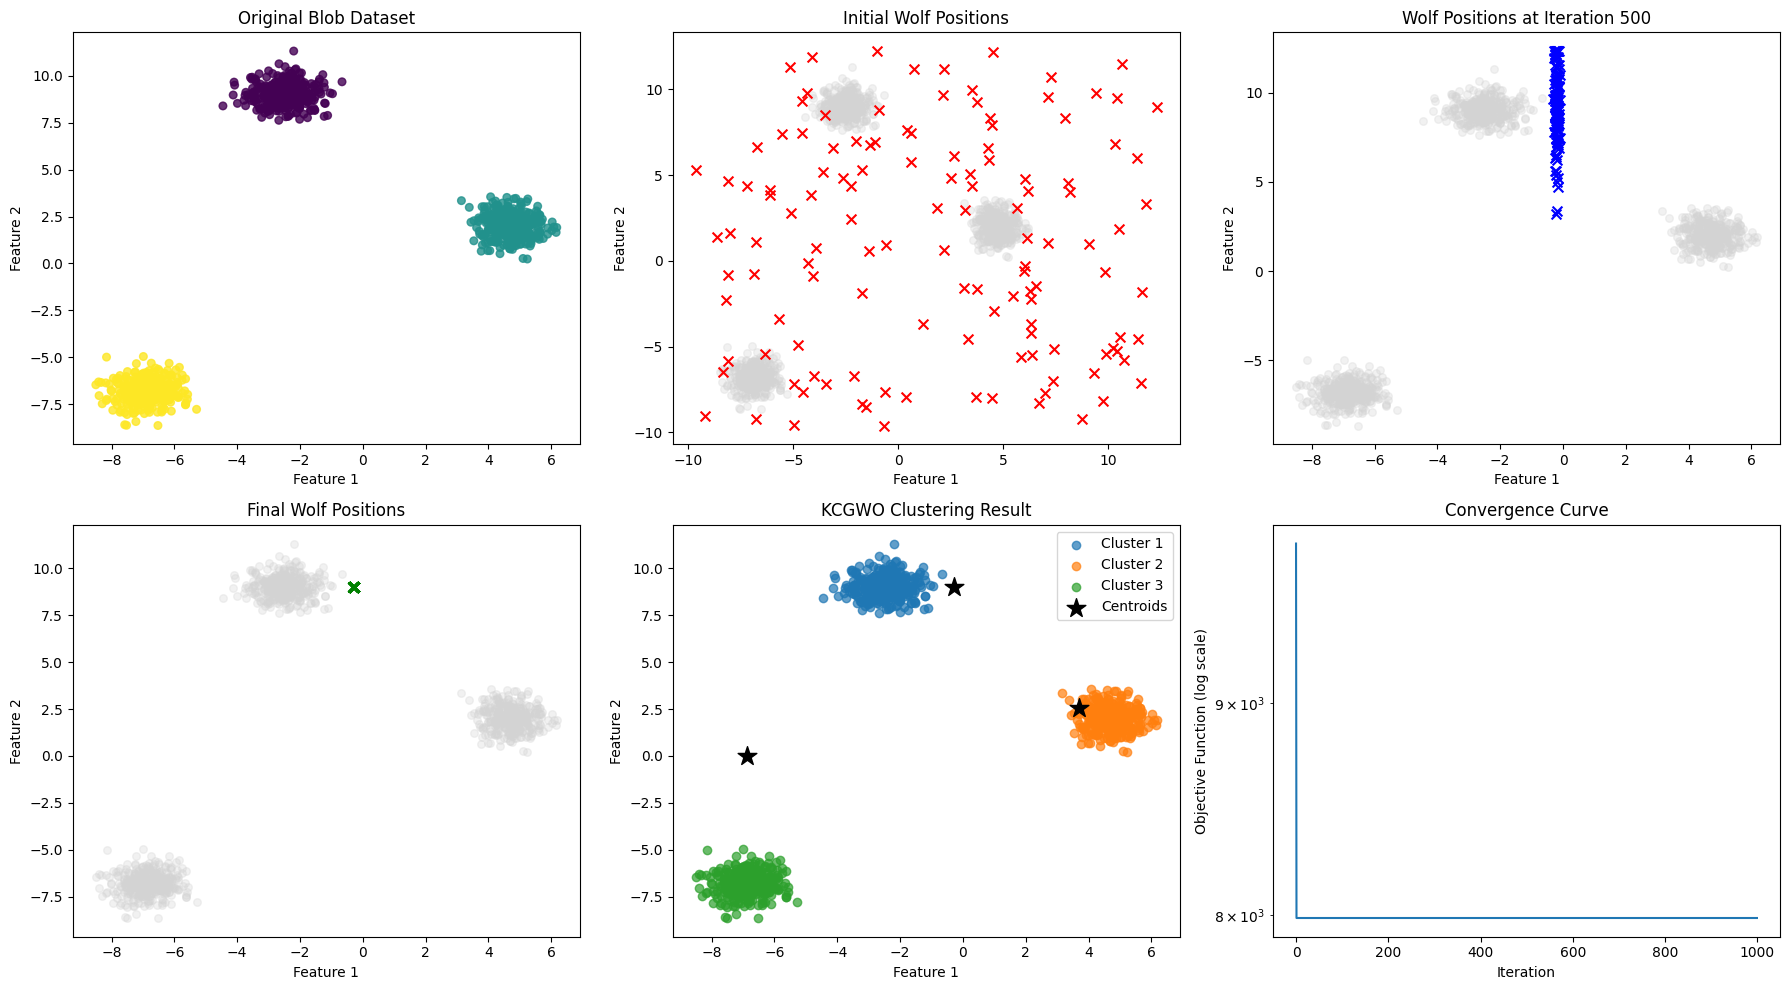

In [ ]:
if __name__ == "__main__":
    # Generate blob dataset
    X, y = generate_blobs(n_samples=1000, centers=3, cluster_std=0.60)

    # Define the optimization problem
    k = 3  # Number of clusters
    dim = k * 2  # Each centroid has x,y coordinates
    search_domain = (np.min(X) - 1, np.max(X) + 1)

    # Define the objective function (taking a flattened vector of centroid coordinates)
    objective = lambda centroids: clustering_objective(centroids, X)

    # Create and run the optimizer
    optimizer = KCGWO(
        objective_function=objective,
        dim=dim,
        search_domain=search_domain,
        pop_size=128,
        max_iter=1000
    )

    # Run the optimization
    best_centroids, best_score, convergence = optimizer.optimize()
    print(f"Best score: {best_score}")
    print(f"Best centroids shape: {best_centroids.shape}")
    print(f"Best centroids:\n{best_centroids.reshape(k, 2)}")

    # Visualize the results
    visualize_clustering(X, y, optimizer.all_positions, best_centroids, k=k)

# **Testeing on real data**

In [ ]:
import pandas as pd

In [ ]:
data_1= pd.read_csv("/content/processed_data.csv")
data_1.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


In [ ]:
data_1.shape

(200, 4)

In [1]:
class KCGWO:
    def __init__(self, n_clusters=3, pop_size=30, max_iter=100):
        """
        Initialize the K-means Clustering based Grey Wolf Optimizer

        Parameters:
        - n_clusters: number of clusters to form
        - pop_size: number of wolves in the pack
        - max_iter: maximum number of iterations
        """
        self.n_clusters = n_clusters
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.best_centroids = None
        self.best_score = float('inf')
        self.convergence_curve = np.zeros(max_iter)
        self.all_positions = []

    def fit(self, X):
        """
        Fit the KCGWO algorithm to the data

        Parameters:
        - X: input data of shape (n_samples, n_features)

        Returns:
        - self: returns an instance of self
        """
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.dim = self.n_clusters * self.n_features  # dimensionality of the search space

        # Determine search domain from data
        self.min_val = np.min(X, axis=0)
        self.max_val = np.max(X, axis=0)

        # Initialize population randomly within the domain
        self.population = self._initialize_population()

        # Initialize fitness values
        self.fitness = np.zeros(self.pop_size)

        # Initialize alpha, beta, and delta positions
        self.alpha_pos = np.zeros(self.dim)
        self.beta_pos = np.zeros(self.dim)
        self.delta_pos = np.zeros(self.dim)
        self.alpha_score = float('inf')
        self.beta_score = float('inf')
        self.delta_score = float('inf')

        # Run the optimization
        self._optimize()

        return self

    def _initialize_population(self):
        """Initialize population of wolves randomly"""
        population = np.zeros((self.pop_size, self.dim))

        for i in range(self.pop_size):
            # Initialize each wolf as a set of centroids
            for j in range(self.n_clusters):
                # Randomly select data points as initial centroids
                idx = np.random.randint(0, self.n_samples)
                for k in range(self.n_features):
                    population[i, j*self.n_features + k] = self.X[idx, k]

        return population

    def _evaluate_fitness(self):
        """Evaluate fitness for all wolves"""
        for i in range(self.pop_size):
            # Reshape wolf position to centroids
            centroids = self.population[i].reshape(self.n_clusters, self.n_features)

            # Calculate distances from all points to all centroids
            distances = np.zeros((self.n_samples, self.n_clusters))
            for j in range(self.n_clusters):
                distances[:, j] = np.sum((self.X - centroids[j])**2, axis=1)

            # Assign points to nearest centroid
            labels = np.argmin(distances, axis=1)

            # Calculate inertia (sum of squared distances to closest centroid)
            inertia = 0
            for j in range(self.n_clusters):
                if np.sum(labels == j) > 0:  # Avoid empty clusters
                    inertia += np.sum(np.min(distances[labels == j], axis=1))

            self.fitness[i] = inertia

            # Update alpha, beta, delta
            if self.fitness[i] < self.alpha_score:
                self.delta_score = self.beta_score
                self.delta_pos = self.beta_pos.copy()
                self.beta_score = self.alpha_score
                self.beta_pos = self.alpha_pos.copy()
                self.alpha_score = self.fitness[i]
                self.alpha_pos = self.population[i].copy()

                # Update best_centroids and best_score
                self.best_centroids = self.alpha_pos.reshape(self.n_clusters, self.n_features)
                self.best_score = self.alpha_score
            elif self.fitness[i] < self.beta_score:
                self.delta_score = self.beta_score
                self.delta_pos = self.beta_pos.copy()
                self.beta_score = self.fitness[i]
                self.beta_pos = self.population[i].copy()
            elif self.fitness[i] < self.delta_score:
                self.delta_score = self.fitness[i]
                self.delta_pos = self.population[i].copy()

    def _cluster_population(self):
        """Cluster the population using K-means (K=3) and return centroids ordered by fitness"""
        # Restructure the population for clustering
        flat_population = self.population.reshape(self.pop_size * self.n_clusters, self.n_features)

        # Apply K-means
        kmeans = KMeans(n_clusters=3, n_init=10)
        labels = kmeans.fit_predict(flat_population)
        centroids = kmeans.cluster_centers_

        # Calculate fitness for each centroid configuration
        centroid_configs = []
        centroid_fitness = []

        # For each centroid from K-means, create a complete set of n_clusters centroids
        for i in range(3):  # K=3 for clustering the wolves
            # Get points in this cluster
            cluster_points = flat_population[labels == i]

            if len(cluster_points) >= self.n_clusters:
                # Randomly sample n_clusters points from this cluster
                indices = np.random.choice(len(cluster_points), self.n_clusters, replace=False)
                config = cluster_points[indices].flatten()

                # Evaluate fitness
                # Reshape for evaluation
                test_centroids = config.reshape(self.n_clusters, self.n_features)

                # Calculate distances and inertia
                distances = np.zeros((self.n_samples, self.n_clusters))
                for j in range(self.n_clusters):
                    distances[:, j] = np.sum((self.X - test_centroids[j])**2, axis=1)

                labels_test = np.argmin(distances, axis=1)
                inertia = 0
                for j in range(self.n_clusters):
                    if np.sum(labels_test == j) > 0:
                        inertia += np.sum(np.min(distances[labels_test == j], axis=1))

                centroid_configs.append(config)
                centroid_fitness.append(inertia)

        # Sort by fitness
        if centroid_configs:  # Check if we have any valid configurations
            centroid_configs = np.array(centroid_configs)
            centroid_fitness = np.array(centroid_fitness)
            sorted_indices = np.argsort(centroid_fitness)

            return centroid_configs[sorted_indices]
        else:
            # If we couldn't create configurations, return current alpha, beta, delta
            return np.array([self.alpha_pos, self.beta_pos, self.delta_pos])

    def _update_positions(self, a):
        """Update positions of wolves based on alpha, beta, delta"""
        for i in range(self.pop_size):
            for d in range(self.dim):
                # For each dimension

                # Calculate distance components
                r1 = np.random.random()
                r2 = np.random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2

                r1 = np.random.random()
                r2 = np.random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2

                r1 = np.random.random()
                r2 = np.random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2

                # Distances to leaders
                D_alpha = abs(C1 * self.alpha_pos[d] - self.population[i, d])
                D_beta = abs(C2 * self.beta_pos[d] - self.population[i, d])
                D_delta = abs(C3 * self.delta_pos[d] - self.population[i, d])

                # Position components
                X1 = self.alpha_pos[d] - A1 * D_alpha
                X2 = self.beta_pos[d] - A2 * D_beta
                X3 = self.delta_pos[d] - A3 * D_delta

                # Weighted position update
                self.population[i, d] = (3*X1 + 2*X2 + X3) / 6

            # Ensure the wolf stays within bounds
            for j in range(self.n_clusters):
                for k in range(self.n_features):
                    idx = j*self.n_features + k
                    self.population[i, idx] = max(min(self.population[i, idx],
                                                     self.max_val[k]),
                                                 self.min_val[k])

    def _optimize(self):
        """Run the KCGWO algorithm"""
        # Store initial positions for visualization
        self.all_positions.append(self.population.copy())

        # Initial fitness evaluation
        self._evaluate_fitness()

        # Main loop
        for t in tqdm(range(self.max_iter)):
            # Store the best score in each iteration for the convergence curve
            self.convergence_curve[t] = self.alpha_score

            # Calculate a for this iteration (linearly decreasing from 2 to 0)
            a = 2 - 2 * (t / self.max_iter)

            # With 50% probability, use K-means clustering to guide the search
            if np.random.random() > 0.5:
                # Use K-means to cluster the population
                sorted_centroids = self._cluster_population()

                if len(sorted_centroids) >= 3:  # Make sure we have enough centroids
                    # Use the clustered centroids as alpha, beta, delta
                    self.alpha_pos = sorted_centroids[0].copy()
                    self.beta_pos = sorted_centroids[1].copy()
                    self.delta_pos = sorted_centroids[2].copy()

            # Update positions of all wolves
            self._update_positions(a)

            # Reevaluate fitness and update alpha, beta, delta
            self._evaluate_fitness()

            # Store positions for visualization
            self.all_positions.append(self.population.copy())

    def predict(self, X=None):
        """
        Predict the closest cluster for each sample in X

        Parameters:
        - X: array-like of shape (n_samples, n_features)
              If None, uses the data passed to fit

        Returns:
        - labels: array of shape (n_samples,)
        """
        if X is None:
            X = self.X

        # Calculate distances from all points to all centroids
        distances = np.zeros((X.shape[0], self.n_clusters))
        for j in range(self.n_clusters):
            distances[:, j] = np.sum((X - self.best_centroids[j])**2, axis=1)

        # Assign points to nearest centroid
        return np.argmin(distances, axis=1)

    def get_centroids(self):
        """Return the cluster centroids"""
        return self.best_centroids

In [ ]:
def visualize_customer_segments(X, labels, centroids, feature_names):
    """
    Visualize customer segments in 3D using the first three features

    Parameters:
    - X: data
    - labels: cluster assignments
    - centroids: cluster centers
    - feature_names: names of the features
    """
    # Plot the 3D scatter plot (first 3 features)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cluster with a different color
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    markers = ['o', 's', '^', 'D', '*', 'p', 'h', 'v', '>', '<']

    for i in range(len(np.unique(labels))):
        ax.scatter(
            X[labels == i, 0],
            X[labels == i, 1],
            X[labels == i, 2],
            c=colors[i % len(colors)],
            marker=markers[i % len(markers)],
            label=f'Cluster {i+1}',
            alpha=0.7,
            s=80
        )

    # Plot centroids
    ax.scatter(
        centroids[:, 0],
        centroids[:, 1],
        centroids[:, 2],
        c='black',
        marker='X',
        s=200,
        label='Centroids'
    )

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.set_title('KCGWO Customer Segmentation', fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot convergence curve
    plt.figure(figsize=(10, 6))
    plt.plot(kcgwo.convergence_curve)
    plt.title('KCGWO Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value (Inertia)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Additional 2D plots for all possible pairs of features
    n_features = X.shape[1]
    if n_features >= 2:
        fig, axes = plt.subplots(1, n_features-1, figsize=(15, 5))

        if n_features == 2:  # Handle the case with only 2 features
            axes = [axes]

        for i in range(n_features-1):
            # Scatter plot for each pair of consecutive features
            for j in range(len(np.unique(labels))):
                axes[i].scatter(
                    X[labels == j, i],
                    X[labels == j, i+1],
                    c=colors[j % len(colors)],
                    marker=markers[j % len(markers)],
                    label=f'Cluster {j+1}',
                    alpha=0.7
                )

            # Plot centroids
            axes[i].scatter(
                centroids[:, i],
                centroids[:, i+1],
                c='black',
                marker='X',
                s=200
            )

            axes[i].set_xlabel(feature_names[i])
            axes[i].set_ylabel(feature_names[i+1])
            axes[i].grid(True)

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(np.unique(labels))+1)
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()

In [ ]:
X = data_1.values

# Choose number of clusters
n_clusters = 3

# Apply KCGWO
kcgwo = KCGWO(n_clusters=n_clusters, pop_size=128, max_iter=1000)
kcgwo.fit(X)

# Get cluster labels
labels = kcgwo.predict()

# Get cluster centroids
centroids = kcgwo.get_centroids()

print(f"KCGWO best score (inertia): {kcgwo.best_score:.4f}")
print("Cluster sizes:", [np.sum(labels == i) for i in range(n_clusters)])
print("Centroids:\n", centroids)

100%|██████████| 1000/1000 [00:35<00:00, 27.98it/s]

KCGWO best score (inertia): 368.4688
Cluster sizes: [np.int64(94), np.int64(66), np.int64(40)]
Centroids:
 [[ 1.0033751   0.02044339 -0.62931384  0.23347862]
 [-1.10290301 -0.66981769  0.11151455  0.        ]
 [-0.35777741  1.28609518  1.33104203  0.28775403]]


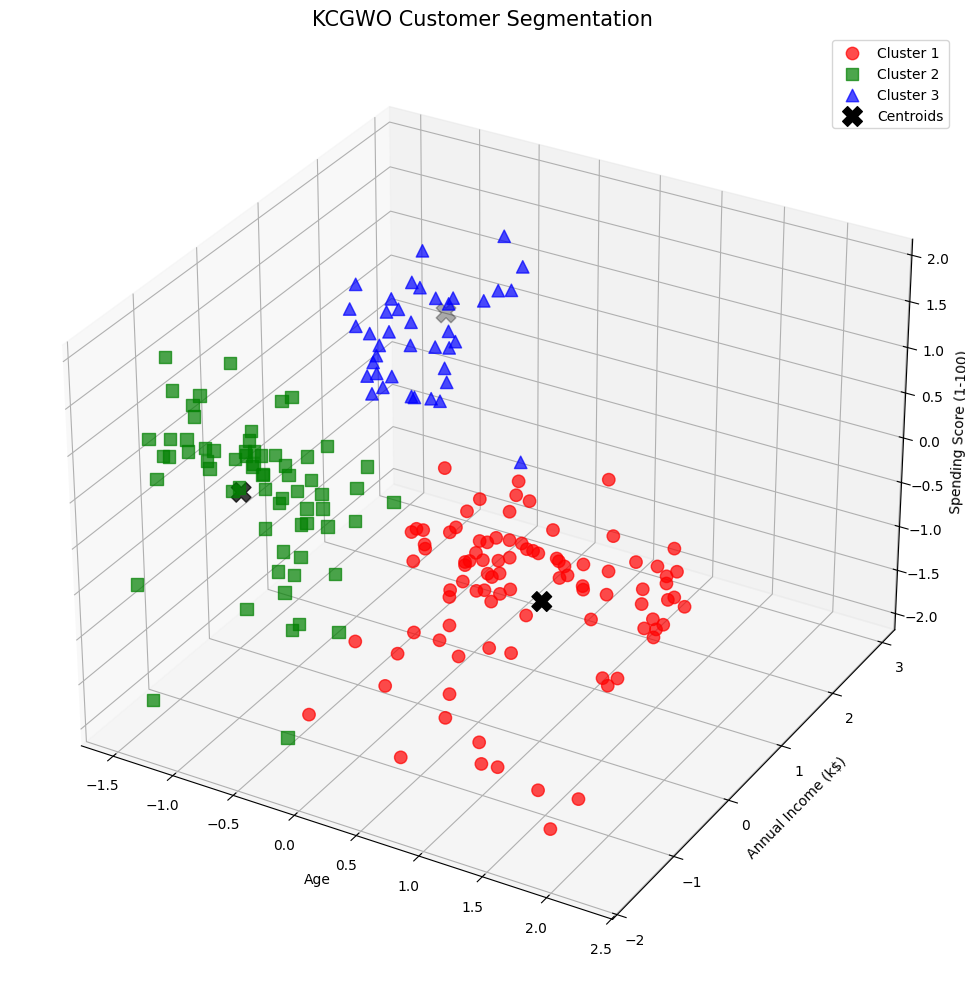

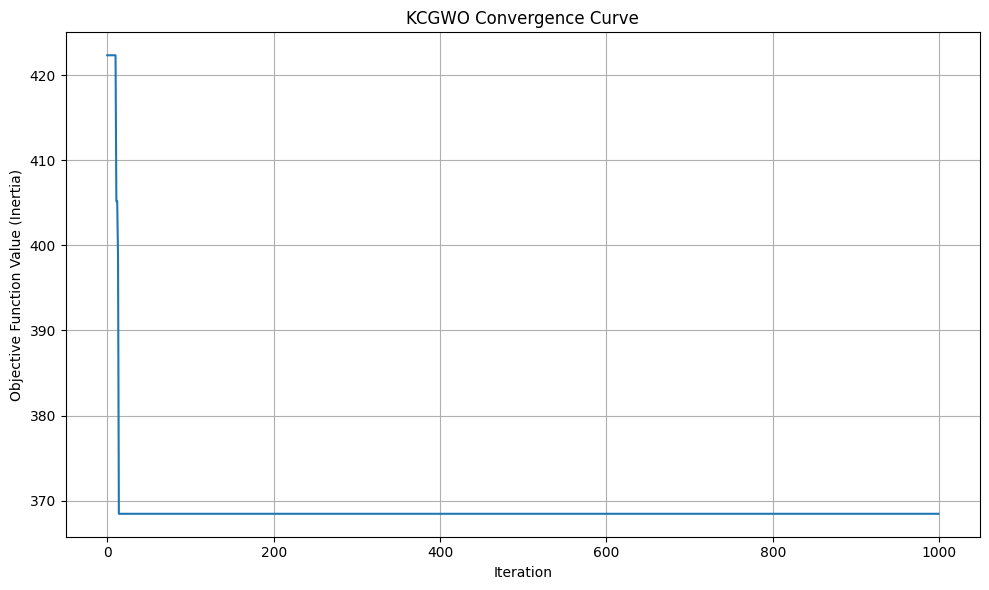

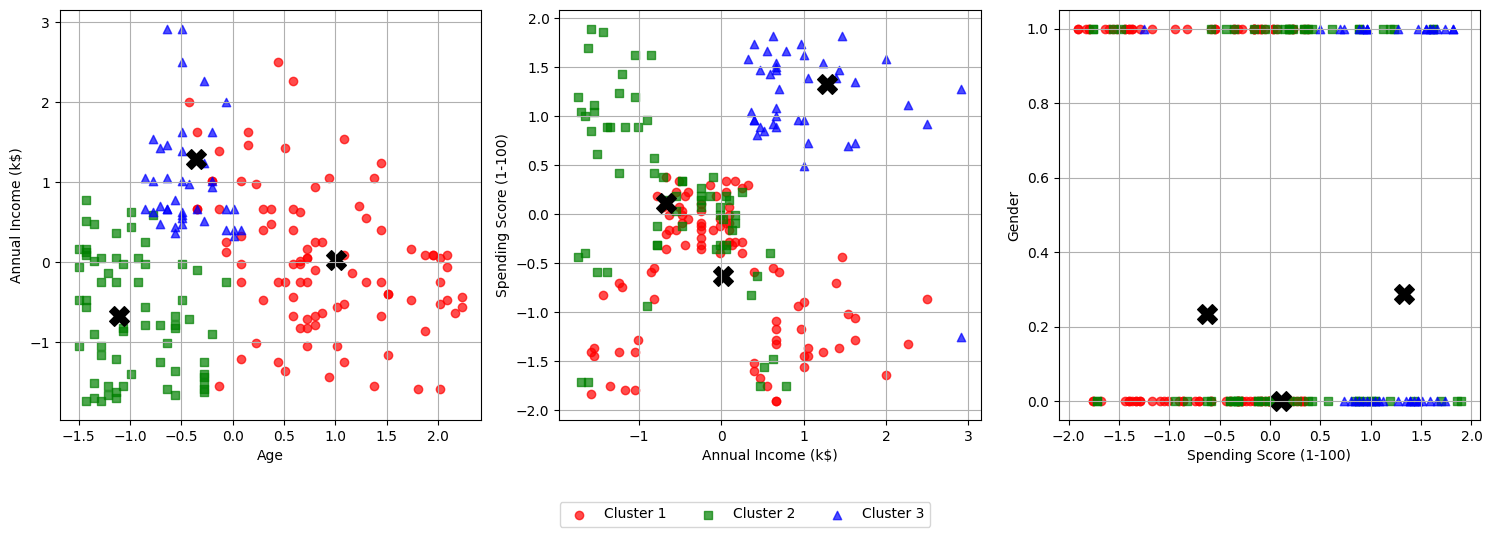

In [ ]:
visualize_customer_segments(X,labels,centroids,data_1.columns)

# **Evaluation metrics**

In [ ]:
# Continue the evaluation with silhouette score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate silhouette score (values closer to 1 indicate better clustering)
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Calculate Davies-Bouldin Index (lower values indicate better clustering)
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

# Calculate Calinski-Harabasz Index (higher values indicate better clustering)
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Silhouette Score: 0.3155
Davies-Bouldin Index: 1.1647
Calinski-Harabasz Index: 87.0519


# **Comparison with kmeans**


Comparison with standard K-means:
K-means inertia: 344.6849
KCGWO inertia: 368.4688
Improvement: -6.90%
K-means Silhouette Score: 0.3150
KCGWO Silhouette Score: 0.3155


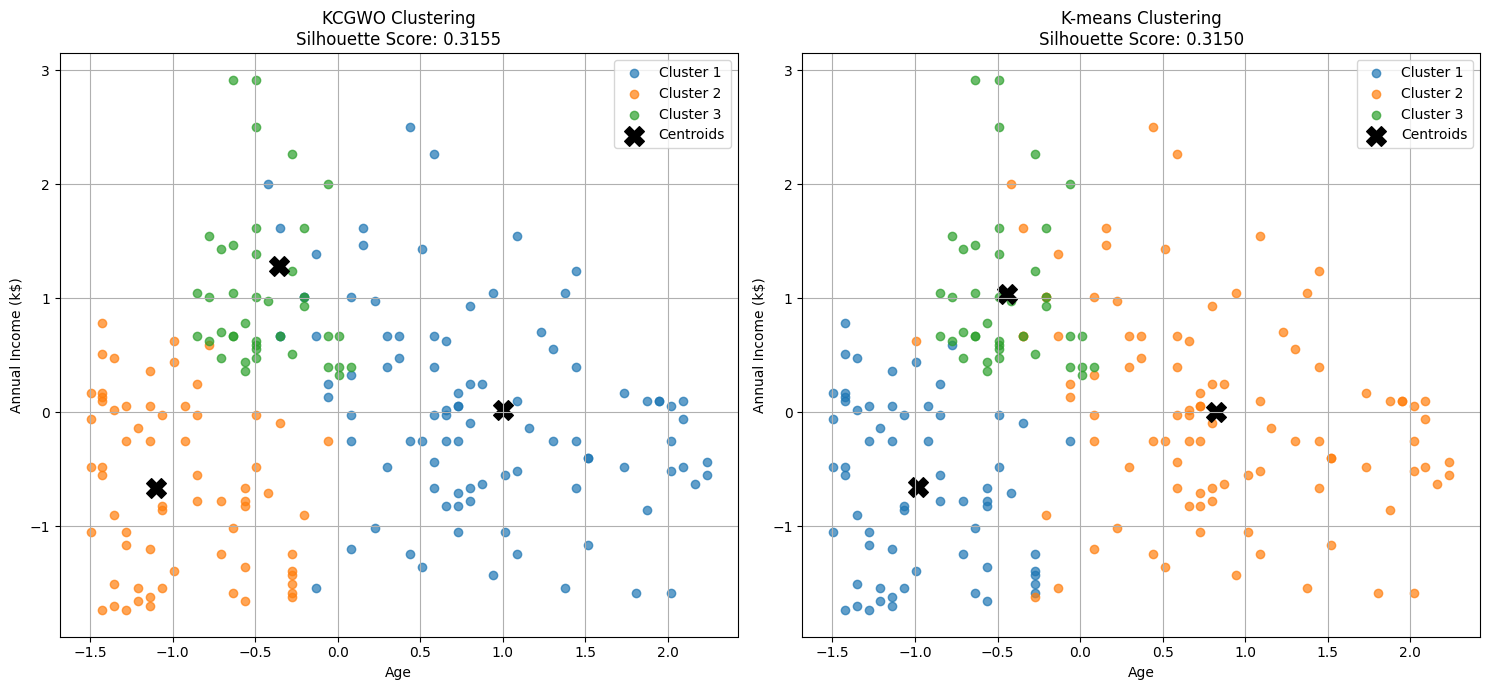

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
kmeans_score = kmeans.inertia_

print("\nComparison with standard K-means:")
print(f"K-means inertia: {kmeans_score:.4f}")
print(f"KCGWO inertia: {kcgwo.best_score:.4f}")
print(f"Improvement: {((kmeans_score - kcgwo.best_score) / kmeans_score) * 100:.2f}%")

# Silhouette score for K-means
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"K-means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"KCGWO Silhouette Score: {silhouette_avg:.4f}")

# Plot comparison of cluster results
plt.figure(figsize=(15, 7))

# Plot KCGWO clustering
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title(f'KCGWO Clustering\nSilhouette Score: {silhouette_avg:.4f}')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend()
plt.grid(True)

# Plot K-means clustering
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    plt.scatter(X[kmeans_labels == i, 0], X[kmeans_labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title(f'K-means Clustering\nSilhouette Score: {kmeans_silhouette:.4f}')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
data_train= pd.read_csv("/content/train_processed_data.csv")
data_train.head()

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0


In [ ]:
data_test = pd.read_csv("/content/test_processed_data.csv")
data_test

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,-0.450948,-0.792867,-1.196222,0,1,1,2,2,5
1,-0.391999,1.696957,0.767498,1,1,1,5,0,5
2,1.494372,-0.792867,-1.196222,0,1,0,0,2,5
3,0.904881,2.630641,-0.541649,1,1,0,4,1,5
4,-1.453083,-0.045920,0.767498,0,0,0,8,2,5
...,...,...,...,...,...,...,...,...,...
2622,-0.863592,2.008185,0.767498,1,0,0,5,2,5
2623,-0.509897,-0.481639,-1.196222,0,0,1,1,2,5
2624,0.551187,0.514290,-0.541649,0,0,1,3,2,5
2625,0.197492,-0.481639,1.422071,1,1,1,4,1,3


In [ ]:
X = data_train.values

# Choose number of clusters
n_clusters = 3

# Apply KCGWO
kcgwo = KCGWO(n_clusters=n_clusters, pop_size=128, max_iter=1000)
kcgwo.fit(X)

# Get cluster labels
labels = kcgwo.predict()

# Get cluster centroids
centroids = kcgwo.get_centroids()

print(f"KCGWO best score (inertia): {kcgwo.best_score:.4f}")
print("Cluster sizes:", [np.sum(labels == i) for i in range(n_clusters)])
print("Centroids:\n", centroids)

100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]

KCGWO best score (inertia): 74923.3898
Cluster sizes: [np.int64(2884), np.int64(1281), np.int64(3903)]
Centroids:
 [[-6.16811840e-02 -4.27220789e-03  4.72181045e-01  1.00000000e+00
   7.50044706e-01  0.00000000e+00  5.67742921e+00  1.69643057e+00
   3.58218313e+00  2.54394935e+00]
 [-8.02146754e-01 -3.20808252e-01  7.72542419e-01  2.54230447e-02
   4.68784334e-01  3.94578347e-01  2.10476210e+00  1.09992544e+00
   1.46792438e+00  1.01139053e+00]
 [ 6.21267358e-02 -8.01541505e-01  3.25300898e-01  5.83319887e-01
   1.00000000e+00  7.35411929e-01  1.16214988e+00  1.35505734e+00
   4.72072805e+00  1.23397851e+00]]


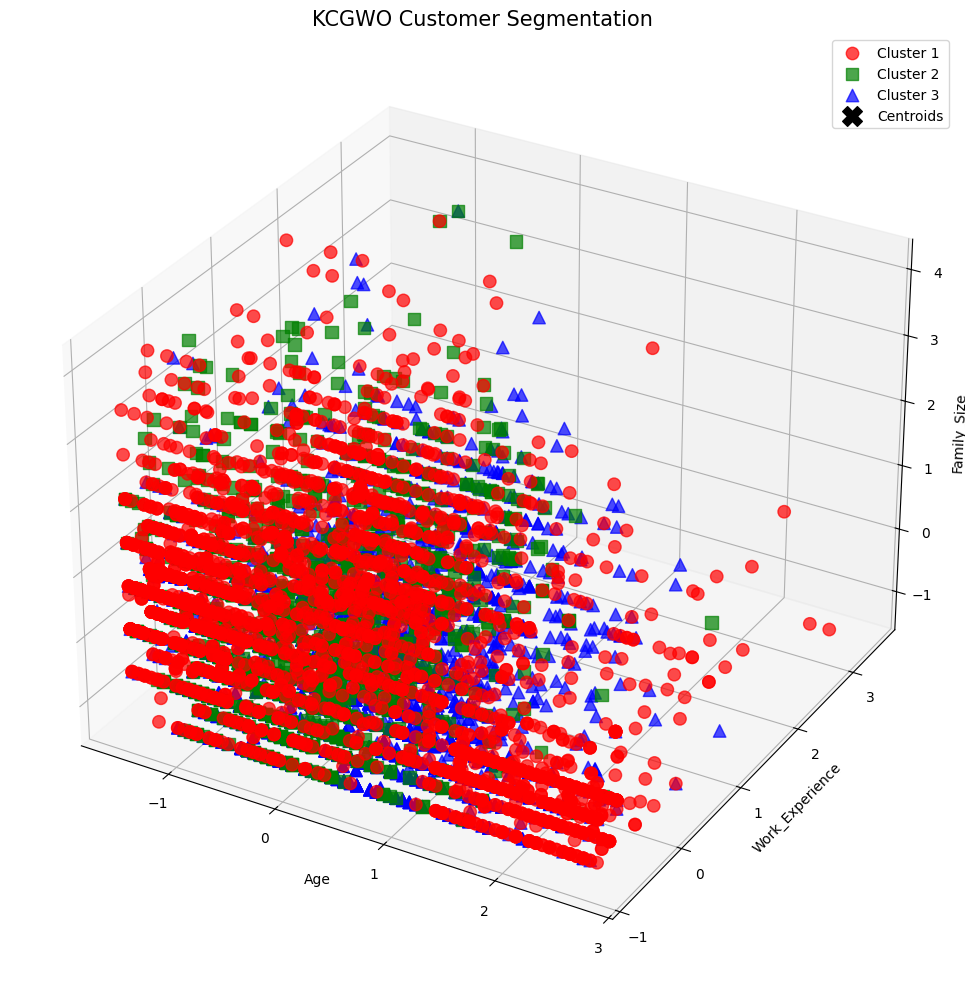

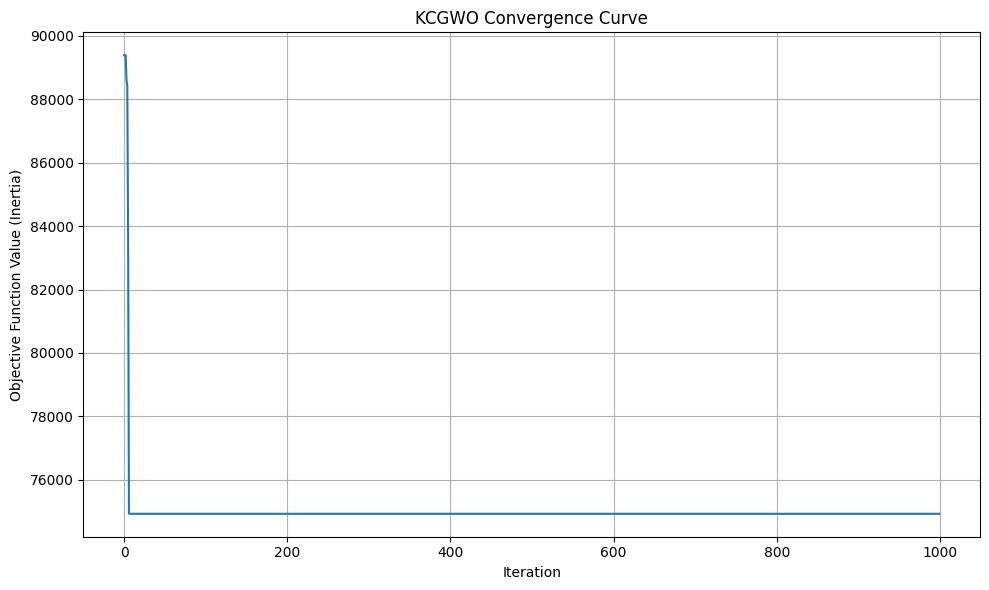

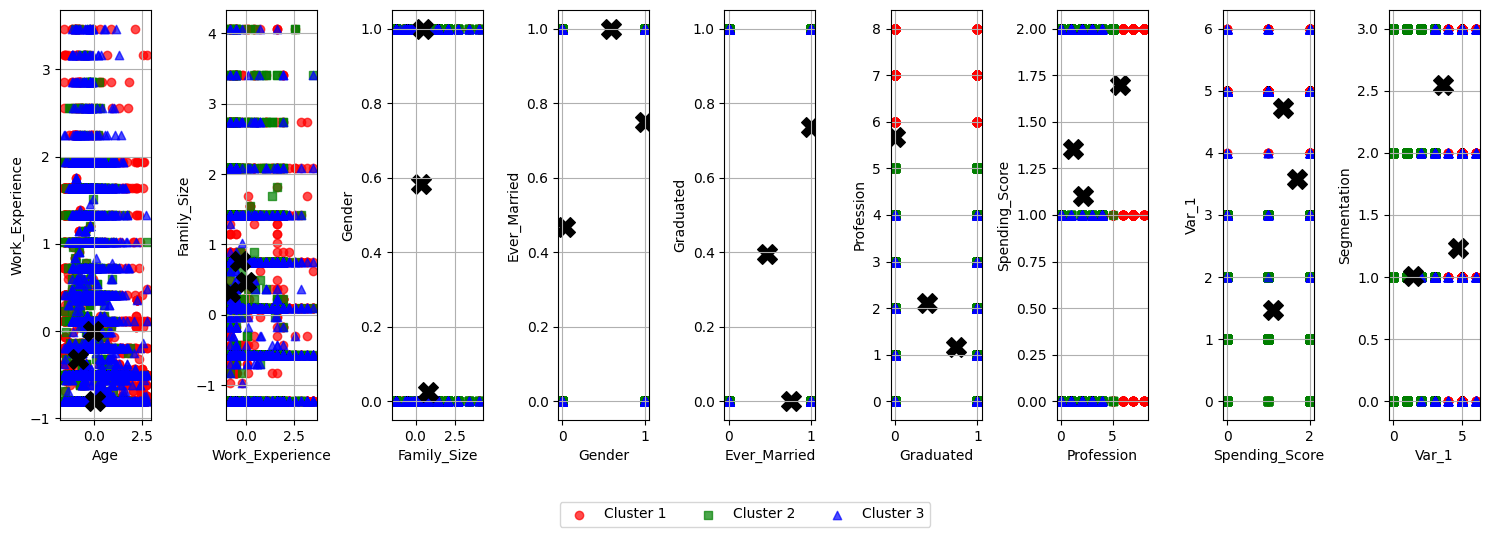

In [ ]:
visualize_customer_segments(X,labels,centroids,data_train.columns)

In [ ]:
# Continue the evaluation with silhouette score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate silhouette score (values closer to 1 indicate better clustering)
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Calculate Davies-Bouldin Index (lower values indicate better clustering)
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

# Calculate Calinski-Harabasz Index (higher values indicate better clustering)
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Silhouette Score: 0.2435
Davies-Bouldin Index: 1.5757
Calinski-Harabasz Index: 3019.4362



Comparison with standard K-means:
K-means inertia: 64199.0430
KCGWO inertia: 74923.3898
Improvement: -16.70%
K-means Silhouette Score: 0.2443
KCGWO Silhouette Score: 0.2435


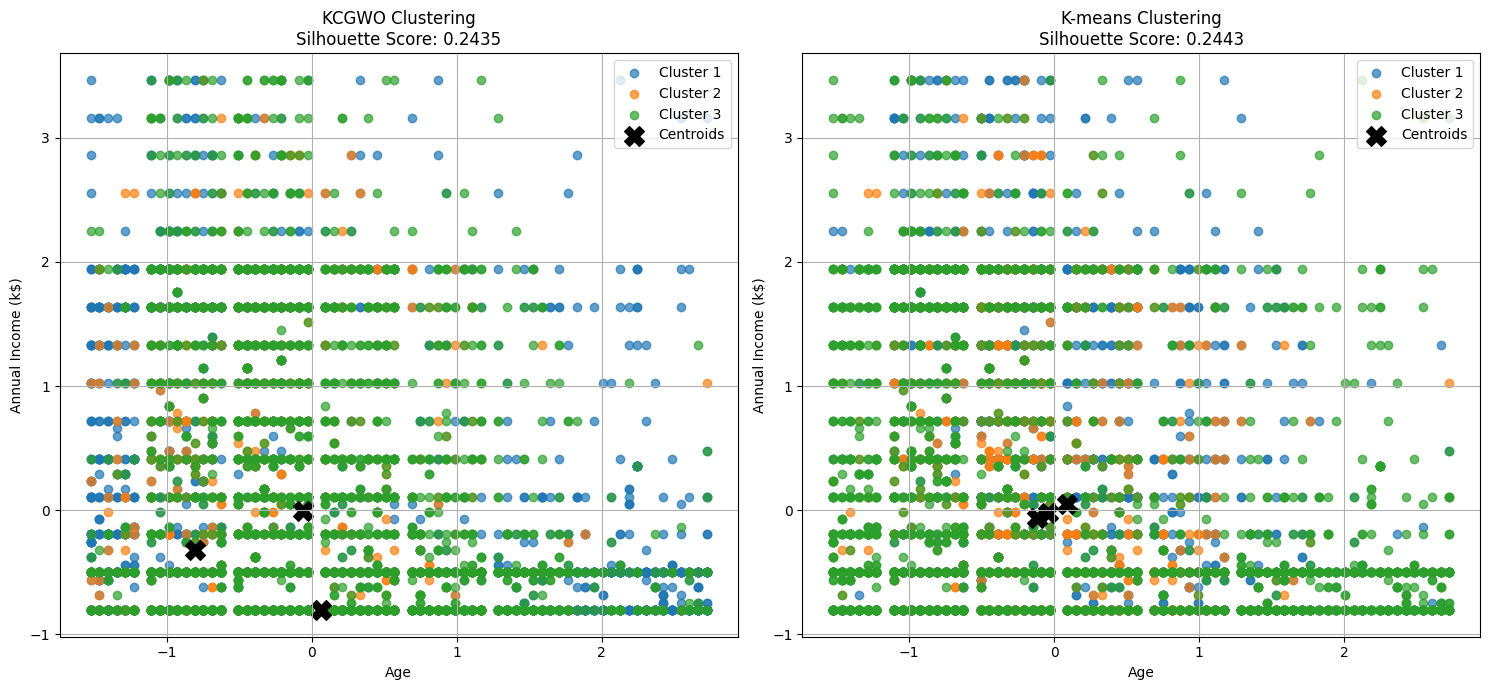

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
kmeans_score = kmeans.inertia_

print("\nComparison with standard K-means:")
print(f"K-means inertia: {kmeans_score:.4f}")
print(f"KCGWO inertia: {kcgwo.best_score:.4f}")
print(f"Improvement: {((kmeans_score - kcgwo.best_score) / kmeans_score) * 100:.2f}%")

# Silhouette score for K-means
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"K-means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"KCGWO Silhouette Score: {silhouette_avg:.4f}")

# Plot comparison of cluster results
plt.figure(figsize=(15, 7))

# Plot KCGWO clustering
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title(f'KCGWO Clustering\nSilhouette Score: {silhouette_avg:.4f}')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend()
plt.grid(True)

# Plot K-means clustering
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    plt.scatter(X[kmeans_labels == i, 0], X[kmeans_labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title(f'K-means Clustering\nSilhouette Score: {kmeans_silhouette:.4f}')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Real testing time**

In [3]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
X.shape

(8068, 10)

In [4]:
import pandas as pd

In [ ]:
X= data_train.values
results={
    "k":[],
    "inertia":[],
    "silhouette":[],
    "ch_score":[],
    "db_score":[]
}

ks= list(range(3,11))

for k in ks:
  print(f"run for k = {k}")
  for run in range(30):
    print(f"run {run}")
    kcgwo= KCGWO(k,128,30)
    kcgwo.fit(X)
    labels= kcgwo.predict()
    inertia = kcgwo.best_score
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X,labels)
    db_score = davies_bouldin_score(X, labels)

    results['k'].append(k)
    results['inertia'].append(inertia)
    results['silhouette'].append(silhouette)
    results['ch_score'].append(ch_score)
    results['db_score'].append(db_score)


run for k = 3
run 0


100%|██████████| 30/30 [00:07<00:00,  4.11it/s]


run 1


100%|██████████| 30/30 [00:07<00:00,  4.19it/s]


run 2


100%|██████████| 30/30 [00:06<00:00,  4.77it/s]


run 3


100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


run 4


100%|██████████| 30/30 [00:06<00:00,  4.69it/s]


run 5


100%|██████████| 30/30 [00:07<00:00,  3.77it/s]


run 6


100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


run 7


100%|██████████| 30/30 [00:06<00:00,  4.81it/s]


run 8


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


run 9


100%|██████████| 30/30 [00:07<00:00,  4.11it/s]


run 10


100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


run 11


100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


run 12


100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


run 13


100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


run 14


100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


run 15


100%|██████████| 30/30 [00:06<00:00,  4.62it/s]


run 16


100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


run 17


100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


run 18


100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


run 19


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


run 20


100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


run 21


100%|██████████| 30/30 [00:06<00:00,  4.95it/s]


run 22


100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


run 23


100%|██████████| 30/30 [00:06<00:00,  4.72it/s]


run 24


100%|██████████| 30/30 [00:06<00:00,  4.66it/s]


run 25


100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


run 26


100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


run 27


100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


run 28


100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


run 29


100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


run for k = 4
run 0


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


run 1


100%|██████████| 30/30 [00:08<00:00,  3.48it/s]


run 2


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


run 3


100%|██████████| 30/30 [00:07<00:00,  3.93it/s]


run 4


100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


run 5


100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


run 6


100%|██████████| 30/30 [00:08<00:00,  3.67it/s]


run 7


100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


run 8


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


run 9


100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


run 10


100%|██████████| 30/30 [00:08<00:00,  3.67it/s]


run 11


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


run 12


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


run 13


100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


run 14


100%|██████████| 30/30 [00:08<00:00,  3.56it/s]


run 15


100%|██████████| 30/30 [00:07<00:00,  3.90it/s]


run 16


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


run 17


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


run 18


100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


run 19


100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


run 20


100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


run 21


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


run 22


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


run 23


100%|██████████| 30/30 [00:07<00:00,  3.97it/s]


run 24


100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


run 25


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


run 26


100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


run 27


100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


run 28


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


run 29


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


run for k = 5
run 0


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]


run 1


100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


run 2


100%|██████████| 30/30 [00:09<00:00,  3.30it/s]


run 3


100%|██████████| 30/30 [00:11<00:00,  2.73it/s]


run 4


100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


run 5


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


run 6


100%|██████████| 30/30 [00:10<00:00,  2.97it/s]


run 7


100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


run 8


100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


run 9


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


run 10


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


run 11


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


run 12


100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


run 13


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


run 14


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


run 15


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


run 16


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


run 17


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


run 18


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


run 19


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


run 20


100%|██████████| 30/30 [00:10<00:00,  2.98it/s]


run 21


100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


run 22


100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


run 23


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


run 24


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


run 25


100%|██████████| 30/30 [00:10<00:00,  2.96it/s]


run 26


100%|██████████| 30/30 [00:10<00:00,  2.97it/s]


run 27


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


run 28


100%|██████████| 30/30 [00:10<00:00,  2.96it/s]


run 29


100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


run for k = 6
run 0


100%|██████████| 30/30 [00:10<00:00,  2.73it/s]


run 1


100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


run 2


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


run 3


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


run 4


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


run 5


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


run 6


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


run 7


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


run 8


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


run 9


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


run 10


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


run 11


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


run 12


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


run 13


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


run 14


100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


run 15


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


run 16


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


run 17


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


run 18


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


run 19


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


run 20


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


run 21


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


run 22


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


run 23


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


run 24


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


run 25


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


run 26


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


run 27


100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


run 28


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


run 29


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


run for k = 7
run 0


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


run 1


100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


run 2


100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


run 3


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


run 4


100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


run 5


100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


run 6


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


run 7


100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


run 8


100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


run 9


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


run 10


100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


run 11


100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


run 12


100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


run 13


100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


run 14


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


run 15


100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


run 16


100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


run 17


100%|██████████| 30/30 [00:13<00:00,  2.31it/s]


run 18


100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


run 19


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


run 20


100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


run 21


100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


run 22


100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


run 23


100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


run 24


100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


run 25


100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


run 26


100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


run 27


100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


run 28


100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


run 29


100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


run for k = 8
run 0


100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


run 1


100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


run 2


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


run 3


100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


run 4


100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


run 5


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


run 6


100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


run 7


100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


run 8


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


run 9


100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


run 10


100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


run 11


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


run 12


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


run 13


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


run 14


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


run 15


100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


run 16


100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


run 17


100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


run 18


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


run 19


100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


run 20


100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


run 21


100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


run 22


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


run 23


100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


run 24


100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


run 25


100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


run 26


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


run 27


100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


run 28


100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


run 29


100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


run for k = 9
run 0


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


run 1


100%|██████████| 30/30 [00:15<00:00,  1.99it/s]


run 2


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


run 3


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


run 4


100%|██████████| 30/30 [00:15<00:00,  1.97it/s]


run 5


100%|██████████| 30/30 [00:15<00:00,  1.99it/s]


run 6


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


run 7


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


run 8


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


run 9


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


run 10


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


run 11


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


run 12


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


run 13


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


run 14


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


run 15


100%|██████████| 30/30 [00:15<00:00,  1.97it/s]


run 16


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


run 17


100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


run 18


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


run 19


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


run 20


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


run 21


100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


run 22


100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


run 23


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


run 24


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


run 25


100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


run 26


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


run 27


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


run 28


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


run 29


100%|██████████| 30/30 [00:15<00:00,  1.97it/s]


run for k = 10
run 0


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


run 1


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


run 2


100%|██████████| 30/30 [00:17<00:00,  1.70it/s]


run 3


100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


run 4


100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


run 5


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


run 6


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


run 7


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


run 8


100%|██████████| 30/30 [00:17<00:00,  1.75it/s]


run 9


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


run 10


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


run 11


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


run 12


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


run 13


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


run 14


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


run 15


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


run 16


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


run 17


100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


run 18


100%|██████████| 30/30 [00:16<00:00,  1.80it/s]


run 19


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


run 20


100%|██████████| 30/30 [00:16<00:00,  1.80it/s]


run 21


100%|██████████| 30/30 [00:17<00:00,  1.70it/s]


run 22


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


run 23


100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


run 24


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


run 25


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


run 26


100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


run 27


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


run 28


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


run 29


100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


In [ ]:
runs_df= pd.DataFrame(results)

In [ ]:
runs_df

,k,inertia,silhouette,ch_score,db_score
0,3,83660.542631,0.232677,2837.259854,1.671143
1,3,75458.474734,0.172668,2890.667532,1.971595
2,3,77456.034264,0.185837,2795.239826,2.129500
3,3,79461.134801,0.225504,2791.572998,1.804664
4,3,78591.766660,0.211478,2923.860919,1.862451
...,...,...,...,...,...
235,10,58534.728928,0.126525,1348.048481,2.200589
236,10,57563.669480,0.160568,1512.717111,1.808192
237,10,59238.380935,0.145871,1388.070792,1.980860
238,10,56690.901824,0.164554,1491.791748,1.831759


In [ ]:
runs_df.to_csv("/content/KCGWO_runs.csv",index=True)

In [ ]:
avarage_df_runs= runs_df.groupby("k").mean()

In [ ]:
avarage_df_runs

,inertia,silhouette,ch_score,db_score
k,,,,
3,78185.609623,0.224002,2873.834792,1.793133
4,72974.405244,0.183295,2327.978993,1.884350
5,69257.571679,0.167770,2030.962520,1.930665
6,66344.820196,0.155311,1789.029417,1.931973
7,64058.474565,0.150933,1662.535878,1.984113
8,61846.064447,0.150352,1557.255727,1.931274
9,59875.336811,0.146185,1471.627857,1.943600
10,57944.492357,0.143553,1410.593184,1.999290


In [ ]:
avarage_df_runs.to_csv("/content/KCGWO_avarage_runs",index=True)

In [5]:
data_test= pd.read_csv("/content/test_processed_data.csv")
data_test

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,-0.450948,-0.792867,-1.196222,0,1,1,2,2,5
1,-0.391999,1.696957,0.767498,1,1,1,5,0,5
2,1.494372,-0.792867,-1.196222,0,1,0,0,2,5
3,0.904881,2.630641,-0.541649,1,1,0,4,1,5
4,-1.453083,-0.045920,0.767498,0,0,0,8,2,5
...,...,...,...,...,...,...,...,...,...
2622,-0.863592,2.008185,0.767498,1,0,0,5,2,5
2623,-0.509897,-0.481639,-1.196222,0,0,1,1,2,5
2624,0.551187,0.514290,-0.541649,0,0,1,3,2,5
2625,0.197492,-0.481639,1.422071,1,1,1,4,1,3


In [6]:
X= data_test.drop("Var_1",axis=1).values
results={
    "k":[],
    "inertia":[],
    "silhouette":[],
    "ch_score":[],
    "db_score":[]
}

ks= list(range(3,11))

for k in ks:
  print(f"run for k = {k}")
  for run in range(30):
    print(f"run {run}")
    kcgwo= KCGWO(k,128,30)
    kcgwo.fit(X)
    labels= kcgwo.predict()
    inertia = kcgwo.best_score
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X,labels)
    db_score = davies_bouldin_score(X, labels)

    results['k'].append(k)
    results['inertia'].append(inertia)
    results['silhouette'].append(silhouette)
    results['ch_score'].append(ch_score)
    results['db_score'].append(db_score)


run for k = 3
run 0


100%|██████████| 30/30 [00:04<00:00,  6.76it/s]


run 1


100%|██████████| 30/30 [00:03<00:00,  8.81it/s]


run 2


100%|██████████| 30/30 [00:03<00:00,  8.54it/s]


run 3


100%|██████████| 30/30 [00:03<00:00,  7.95it/s]


run 4


100%|██████████| 30/30 [00:04<00:00,  7.34it/s]


run 5


100%|██████████| 30/30 [00:03<00:00,  8.90it/s]


run 6


100%|██████████| 30/30 [00:03<00:00,  8.87it/s]


run 7


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


run 8


100%|██████████| 30/30 [00:03<00:00,  8.39it/s]


run 9


100%|██████████| 30/30 [00:03<00:00,  8.48it/s]


run 10


100%|██████████| 30/30 [00:04<00:00,  6.49it/s]


run 11


100%|██████████| 30/30 [00:03<00:00,  8.10it/s]


run 12


100%|██████████| 30/30 [00:03<00:00,  8.88it/s]


run 13


100%|██████████| 30/30 [00:05<00:00,  5.53it/s]


run 14


100%|██████████| 30/30 [00:04<00:00,  6.82it/s]


run 15


100%|██████████| 30/30 [00:04<00:00,  6.47it/s]


run 16


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


run 17


100%|██████████| 30/30 [00:03<00:00,  8.54it/s]


run 18


100%|██████████| 30/30 [00:03<00:00,  8.26it/s]


run 19


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


run 20


100%|██████████| 30/30 [00:03<00:00,  8.73it/s]


run 21


100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


run 22


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


run 23


100%|██████████| 30/30 [00:03<00:00,  8.59it/s]


run 24


100%|██████████| 30/30 [00:03<00:00,  8.92it/s]


run 25


100%|██████████| 30/30 [00:04<00:00,  7.29it/s]


run 26


100%|██████████| 30/30 [00:03<00:00,  7.75it/s]


run 27


100%|██████████| 30/30 [00:03<00:00,  8.89it/s]


run 28


100%|██████████| 30/30 [00:03<00:00,  8.42it/s]


run 29


100%|██████████| 30/30 [00:04<00:00,  7.31it/s]


run for k = 4
run 0


100%|██████████| 30/30 [00:04<00:00,  6.90it/s]


run 1


100%|██████████| 30/30 [00:04<00:00,  6.27it/s]


run 2


100%|██████████| 30/30 [00:04<00:00,  6.24it/s]


run 3


100%|██████████| 30/30 [00:04<00:00,  6.82it/s]


run 4


100%|██████████| 30/30 [00:05<00:00,  5.68it/s]


run 5


100%|██████████| 30/30 [00:04<00:00,  7.10it/s]


run 6


100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


run 7


100%|██████████| 30/30 [00:05<00:00,  5.71it/s]


run 8


100%|██████████| 30/30 [00:04<00:00,  6.97it/s]


run 9


100%|██████████| 30/30 [00:05<00:00,  5.89it/s]


run 10


100%|██████████| 30/30 [00:04<00:00,  6.78it/s]


run 11


100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


run 12


100%|██████████| 30/30 [00:05<00:00,  5.77it/s]


run 13


100%|██████████| 30/30 [00:04<00:00,  7.08it/s]


run 14


100%|██████████| 30/30 [00:04<00:00,  7.06it/s]


run 15


100%|██████████| 30/30 [00:05<00:00,  5.86it/s]


run 16


100%|██████████| 30/30 [00:04<00:00,  7.25it/s]


run 17


100%|██████████| 30/30 [00:04<00:00,  6.06it/s]


run 18


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


run 19


100%|██████████| 30/30 [00:04<00:00,  6.83it/s]


run 20


100%|██████████| 30/30 [00:05<00:00,  5.51it/s]


run 21


100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


run 22


100%|██████████| 30/30 [00:04<00:00,  6.33it/s]


run 23


100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


run 24


100%|██████████| 30/30 [00:04<00:00,  6.82it/s]


run 25


100%|██████████| 30/30 [00:05<00:00,  5.64it/s]


run 26


100%|██████████| 30/30 [00:04<00:00,  6.90it/s]


run 27


100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


run 28


100%|██████████| 30/30 [00:05<00:00,  5.82it/s]


run 29


100%|██████████| 30/30 [00:04<00:00,  7.27it/s]


run for k = 5
run 0


100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


run 1


100%|██████████| 30/30 [00:05<00:00,  5.85it/s]


run 2


100%|██████████| 30/30 [00:04<00:00,  6.19it/s]


run 3


100%|██████████| 30/30 [00:06<00:00,  4.92it/s]


run 4


100%|██████████| 30/30 [00:04<00:00,  6.10it/s]


run 5


100%|██████████| 30/30 [00:05<00:00,  5.14it/s]


run 6


100%|██████████| 30/30 [00:05<00:00,  5.91it/s]


run 7


100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


run 8


100%|██████████| 30/30 [00:04<00:00,  6.19it/s]


run 9


100%|██████████| 30/30 [00:04<00:00,  6.03it/s]


run 10


100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


run 11


100%|██████████| 30/30 [00:04<00:00,  6.13it/s]


run 12


100%|██████████| 30/30 [00:05<00:00,  5.04it/s]


run 13


100%|██████████| 30/30 [00:04<00:00,  6.10it/s]


run 14


100%|██████████| 30/30 [00:06<00:00,  4.61it/s]


run 15


100%|██████████| 30/30 [00:05<00:00,  5.86it/s]


run 16


100%|██████████| 30/30 [00:05<00:00,  5.37it/s]


run 17


100%|██████████| 30/30 [00:05<00:00,  5.48it/s]


run 18


100%|██████████| 30/30 [00:04<00:00,  6.16it/s]


run 19


100%|██████████| 30/30 [00:06<00:00,  5.00it/s]


run 20


100%|██████████| 30/30 [00:04<00:00,  6.13it/s]


run 21


100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


run 22


100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


run 23


100%|██████████| 30/30 [00:06<00:00,  4.97it/s]


run 24


100%|██████████| 30/30 [00:05<00:00,  5.98it/s]


run 25


100%|██████████| 30/30 [00:05<00:00,  5.96it/s]


run 26


100%|██████████| 30/30 [00:05<00:00,  5.45it/s]


run 27


100%|██████████| 30/30 [00:04<00:00,  6.25it/s]


run 28


100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


run 29


100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


run for k = 6
run 0


100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


run 1


100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


run 2


100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


run 3


100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


run 4


100%|██████████| 30/30 [00:06<00:00,  4.41it/s]


run 5


100%|██████████| 30/30 [00:05<00:00,  5.41it/s]


run 6


100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


run 7


100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


run 8


100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


run 9


100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


run 10


100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


run 11


100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


run 12


100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


run 13


100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


run 14


100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


run 15


100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


run 16


100%|██████████| 30/30 [00:06<00:00,  4.44it/s]


run 17


100%|██████████| 30/30 [00:05<00:00,  5.27it/s]


run 18


100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


run 19


100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


run 20


100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


run 21


100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


run 22


100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


run 23


100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


run 24


100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


run 25


100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


run 26


100%|██████████| 30/30 [00:06<00:00,  4.43it/s]


run 27


100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


run 28


100%|██████████| 30/30 [00:06<00:00,  4.49it/s]


run 29


100%|██████████| 30/30 [00:05<00:00,  5.38it/s]


run for k = 7
run 0


100%|██████████| 30/30 [00:07<00:00,  3.96it/s]


run 1


100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


run 2


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


run 3


100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


run 4


100%|██████████| 30/30 [00:07<00:00,  4.22it/s]


run 5


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


run 6


100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


run 7


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


run 8


100%|██████████| 30/30 [00:06<00:00,  4.81it/s]


run 9


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


run 10


100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


run 11


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


run 12


100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


run 13


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


run 14


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


run 15


100%|██████████| 30/30 [00:06<00:00,  4.73it/s]


run 16


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


run 17


100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


run 18


100%|██████████| 30/30 [00:07<00:00,  3.94it/s]


run 19


100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


run 20


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


run 21


100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


run 22


100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


run 23


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


run 24


100%|██████████| 30/30 [00:06<00:00,  4.71it/s]


run 25


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


run 26


100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


run 27


100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


run 28


100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


run 29


100%|██████████| 30/30 [00:07<00:00,  4.24it/s]


run for k = 8
run 0


100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


run 1


100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


run 2


100%|██████████| 30/30 [00:08<00:00,  3.56it/s]


run 3


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


run 4


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


run 5


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


run 6


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


run 7


100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


run 8


100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


run 9


100%|██████████| 30/30 [00:07<00:00,  4.22it/s]


run 10


100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


run 11


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


run 12


100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


run 13


100%|██████████| 30/30 [00:08<00:00,  3.56it/s]


run 14


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


run 15


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


run 16


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


run 17


100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


run 18


100%|██████████| 30/30 [00:08<00:00,  3.58it/s]


run 19


100%|██████████| 30/30 [00:08<00:00,  3.67it/s]


run 20


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


run 21


100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


run 22


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


run 23


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


run 24


100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


run 25


100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


run 26


100%|██████████| 30/30 [00:08<00:00,  3.75it/s]


run 27


100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


run 28


100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


run 29


100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


run for k = 9
run 0


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


run 1


100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


run 2


100%|██████████| 30/30 [00:08<00:00,  3.36it/s]


run 3


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


run 4


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


run 5


100%|██████████| 30/30 [00:08<00:00,  3.40it/s]


run 6


100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


run 7


100%|██████████| 30/30 [00:07<00:00,  3.94it/s]


run 8


100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


run 9


100%|██████████| 30/30 [00:08<00:00,  3.34it/s]


run 10


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


run 11


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


run 12


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


run 13


100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


run 14


100%|██████████| 30/30 [00:08<00:00,  3.45it/s]


run 15


100%|██████████| 30/30 [00:08<00:00,  3.35it/s]


run 16


100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


run 17


100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


run 18


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


run 19


100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


run 20


100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


run 21


100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


run 22


100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


run 23


100%|██████████| 30/30 [00:08<00:00,  3.74it/s]


run 24


100%|██████████| 30/30 [00:08<00:00,  3.40it/s]


run 25


100%|██████████| 30/30 [00:08<00:00,  3.34it/s]


run 26


100%|██████████| 30/30 [00:07<00:00,  3.88it/s]


run 27


100%|██████████| 30/30 [00:08<00:00,  3.36it/s]


run 28


100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


run 29


100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


run for k = 10
run 0


100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


run 1


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


run 2


100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


run 3


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


run 4


100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


run 5


100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


run 6


100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


run 7


100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


run 8


100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


run 9


100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


run 10


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


run 11


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


run 12


100%|██████████| 30/30 [00:09<00:00,  3.03it/s]


run 13


100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


run 14


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


run 15


100%|██████████| 30/30 [00:08<00:00,  3.45it/s]


run 16


100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


run 17


100%|██████████| 30/30 [00:09<00:00,  3.06it/s]


run 18


100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


run 19


100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


run 20


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


run 21


100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


run 22


100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


run 23


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


run 24


100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


run 25


100%|██████████| 30/30 [00:09<00:00,  3.09it/s]


run 26


100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


run 27


100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


run 28


100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


run 29


100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


In [7]:
runs_df= pd.DataFrame(results)

In [8]:
runs_df

,k,inertia,silhouette,ch_score,db_score
0,3,16247.963866,0.233304,1431.683532,1.679937
1,3,14224.508529,0.321261,1733.641605,1.255554
2,3,15025.436136,0.331043,1709.847485,1.179436
3,3,15520.508270,0.252148,1625.740636,1.468381
4,3,15480.772536,0.252496,1445.353582,1.647484
...,...,...,...,...,...
235,10,10667.248899,0.178088,773.555886,1.610193
236,10,10213.944564,0.174217,718.850016,1.818008
237,10,10489.225048,0.219407,750.163758,1.727285
238,10,10665.372617,0.175580,747.750819,1.704781


In [9]:
runs_df.to_csv("/content/KCGWO_Test_runs.csv",index=True)

In [10]:
avarage_df_runs= runs_df.groupby("k").mean()

In [11]:
avarage_df_runs

,inertia,silhouette,ch_score,db_score
k,,,,
3,15183.945673,0.289979,1630.482065,1.361912
4,13989.824092,0.241452,1314.266087,1.544172
5,13345.108607,0.217615,1137.311660,1.622595
6,12502.007425,0.207532,1016.637074,1.649118
7,12021.633063,0.194823,912.180905,1.706988
8,11264.185726,0.197281,859.638317,1.716375
9,10687.436422,0.211356,830.807764,1.602664
10,10424.835635,0.190450,764.064079,1.703178


In [12]:
avarage_df_runs.to_csv("/content/KCGWO_Test_avarage_runs",index=True)

In [13]:
data = pd.read_csv("/content/processed_data.csv")

In [14]:
data

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,0
196,0.441365,2.497807,-0.861839,0
197,-0.491602,2.497807,0.923953,1
198,-0.491602,2.917671,-1.250054,1


In [15]:
X= data.values
results={
    "k":[],
    "inertia":[],
    "silhouette":[],
    "ch_score":[],
    "db_score":[]
}

ks= list(range(3,11))

for k in ks:
  print(f"run for k = {k}")
  for run in range(30):
    print(f"run {run}")
    kcgwo= KCGWO(k,128,30)
    kcgwo.fit(X)
    labels= kcgwo.predict()
    inertia = kcgwo.best_score
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X,labels)
    db_score = davies_bouldin_score(X, labels)

    results['k'].append(k)
    results['inertia'].append(inertia)
    results['silhouette'].append(silhouette)
    results['ch_score'].append(ch_score)
    results['db_score'].append(db_score)


run for k = 3
run 0


100%|██████████| 30/30 [00:01<00:00, 26.89it/s]


run 1


100%|██████████| 30/30 [00:01<00:00, 23.99it/s]


run 2


100%|██████████| 30/30 [00:01<00:00, 16.73it/s]


run 3


100%|██████████| 30/30 [00:01<00:00, 17.64it/s]


run 4


100%|██████████| 30/30 [00:01<00:00, 26.56it/s]


run 5


100%|██████████| 30/30 [00:01<00:00, 25.20it/s]


run 6


100%|██████████| 30/30 [00:01<00:00, 24.74it/s]


run 7


100%|██████████| 30/30 [00:01<00:00, 24.19it/s]


run 8


100%|██████████| 30/30 [00:01<00:00, 25.25it/s]


run 9


100%|██████████| 30/30 [00:01<00:00, 24.31it/s]


run 10


100%|██████████| 30/30 [00:01<00:00, 25.43it/s]


run 11


100%|██████████| 30/30 [00:01<00:00, 26.12it/s]


run 12


100%|██████████| 30/30 [00:01<00:00, 16.73it/s]


run 13


100%|██████████| 30/30 [00:01<00:00, 18.76it/s]


run 14


100%|██████████| 30/30 [00:01<00:00, 24.91it/s]


run 15


100%|██████████| 30/30 [00:01<00:00, 26.31it/s]


run 16


100%|██████████| 30/30 [00:01<00:00, 27.35it/s]


run 17


100%|██████████| 30/30 [00:01<00:00, 25.79it/s]


run 18


100%|██████████| 30/30 [00:01<00:00, 25.52it/s]


run 19


100%|██████████| 30/30 [00:01<00:00, 23.00it/s]


run 20


100%|██████████| 30/30 [00:01<00:00, 25.08it/s]


run 21


100%|██████████| 30/30 [00:01<00:00, 23.09it/s]


run 22


100%|██████████| 30/30 [00:01<00:00, 16.74it/s]


run 23


100%|██████████| 30/30 [00:01<00:00, 20.88it/s]


run 24


100%|██████████| 30/30 [00:01<00:00, 23.82it/s]


run 25


100%|██████████| 30/30 [00:01<00:00, 25.42it/s]


run 26


100%|██████████| 30/30 [00:01<00:00, 23.58it/s]


run 27


100%|██████████| 30/30 [00:01<00:00, 23.28it/s]


run 28


100%|██████████| 30/30 [00:01<00:00, 24.16it/s]


run 29


100%|██████████| 30/30 [00:01<00:00, 27.31it/s]


run for k = 4
run 0


100%|██████████| 30/30 [00:01<00:00, 20.84it/s]


run 1


100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


run 2


100%|██████████| 30/30 [00:01<00:00, 17.08it/s]


run 3


100%|██████████| 30/30 [00:01<00:00, 19.32it/s]


run 4


100%|██████████| 30/30 [00:01<00:00, 21.70it/s]


run 5


100%|██████████| 30/30 [00:01<00:00, 20.23it/s]


run 6


100%|██████████| 30/30 [00:01<00:00, 20.00it/s]


run 7


100%|██████████| 30/30 [00:01<00:00, 20.04it/s]


run 8


100%|██████████| 30/30 [00:01<00:00, 16.21it/s]


run 9


100%|██████████| 30/30 [00:02<00:00, 13.07it/s]


run 10


100%|██████████| 30/30 [00:01<00:00, 19.91it/s]


run 11


100%|██████████| 30/30 [00:01<00:00, 20.94it/s]


run 12


100%|██████████| 30/30 [00:01<00:00, 19.61it/s]


run 13


100%|██████████| 30/30 [00:01<00:00, 20.76it/s]


run 14


100%|██████████| 30/30 [00:01<00:00, 19.09it/s]


run 15


100%|██████████| 30/30 [00:01<00:00, 20.58it/s]


run 16


100%|██████████| 30/30 [00:01<00:00, 16.91it/s]


run 17


100%|██████████| 30/30 [00:02<00:00, 13.51it/s]


run 18


100%|██████████| 30/30 [00:01<00:00, 19.57it/s]


run 19


100%|██████████| 30/30 [00:01<00:00, 21.02it/s]


run 20


100%|██████████| 30/30 [00:01<00:00, 19.94it/s]


run 21


100%|██████████| 30/30 [00:01<00:00, 19.79it/s]


run 22


100%|██████████| 30/30 [00:01<00:00, 19.53it/s]


run 23


100%|██████████| 30/30 [00:01<00:00, 21.04it/s]


run 24


100%|██████████| 30/30 [00:01<00:00, 15.31it/s]


run 25


100%|██████████| 30/30 [00:02<00:00, 14.25it/s]


run 26


100%|██████████| 30/30 [00:01<00:00, 21.47it/s]


run 27


100%|██████████| 30/30 [00:01<00:00, 20.35it/s]


run 28


100%|██████████| 30/30 [00:01<00:00, 21.41it/s]


run 29


100%|██████████| 30/30 [00:01<00:00, 21.05it/s]


run for k = 5
run 0


100%|██████████| 30/30 [00:01<00:00, 16.31it/s]


run 1


100%|██████████| 30/30 [00:01<00:00, 16.03it/s]


run 2


100%|██████████| 30/30 [00:02<00:00, 10.91it/s]


run 3


100%|██████████| 30/30 [00:01<00:00, 16.90it/s]


run 4


100%|██████████| 30/30 [00:01<00:00, 16.73it/s]


run 5


100%|██████████| 30/30 [00:01<00:00, 17.86it/s]


run 6


100%|██████████| 30/30 [00:01<00:00, 17.80it/s]


run 7


100%|██████████| 30/30 [00:01<00:00, 16.84it/s]


run 8


100%|██████████| 30/30 [00:02<00:00, 13.13it/s]


run 9


100%|██████████| 30/30 [00:02<00:00, 12.65it/s]


run 10


100%|██████████| 30/30 [00:01<00:00, 16.82it/s]


run 11


100%|██████████| 30/30 [00:01<00:00, 17.40it/s]


run 12


100%|██████████| 30/30 [00:01<00:00, 17.60it/s]


run 13


100%|██████████| 30/30 [00:01<00:00, 17.28it/s]


run 14


100%|██████████| 30/30 [00:01<00:00, 17.28it/s]


run 15


100%|██████████| 30/30 [00:02<00:00, 11.38it/s]


run 16


100%|██████████| 30/30 [00:01<00:00, 15.16it/s]


run 17


100%|██████████| 30/30 [00:01<00:00, 17.11it/s]


run 18


100%|██████████| 30/30 [00:01<00:00, 16.54it/s]


run 19


100%|██████████| 30/30 [00:01<00:00, 16.48it/s]


run 20


100%|██████████| 30/30 [00:01<00:00, 17.47it/s]


run 21


100%|██████████| 30/30 [00:02<00:00, 14.57it/s]


run 22


100%|██████████| 30/30 [00:02<00:00, 11.95it/s]


run 23


100%|██████████| 30/30 [00:01<00:00, 15.90it/s]


run 24


100%|██████████| 30/30 [00:01<00:00, 16.01it/s]


run 25


100%|██████████| 30/30 [00:01<00:00, 16.87it/s]


run 26


100%|██████████| 30/30 [00:01<00:00, 16.37it/s]


run 27


100%|██████████| 30/30 [00:01<00:00, 16.82it/s]


run 28


100%|██████████| 30/30 [00:02<00:00, 10.78it/s]


run 29


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


run for k = 6
run 0


100%|██████████| 30/30 [00:02<00:00, 13.70it/s]


run 1


100%|██████████| 30/30 [00:02<00:00, 11.46it/s]


run 2


100%|██████████| 30/30 [00:02<00:00, 14.69it/s]


run 3


100%|██████████| 30/30 [00:02<00:00, 11.46it/s]


run 4


100%|██████████| 30/30 [00:02<00:00, 11.36it/s]


run 5


100%|██████████| 30/30 [00:02<00:00, 14.36it/s]


run 6


100%|██████████| 30/30 [00:02<00:00, 14.93it/s]


run 7


100%|██████████| 30/30 [00:02<00:00, 14.51it/s]


run 8


100%|██████████| 30/30 [00:02<00:00, 14.01it/s]


run 9


100%|██████████| 30/30 [00:03<00:00,  9.57it/s]


run 10


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


run 11


100%|██████████| 30/30 [00:01<00:00, 15.19it/s]


run 12


100%|██████████| 30/30 [00:01<00:00, 15.59it/s]


run 13


100%|██████████| 30/30 [00:02<00:00, 14.02it/s]


run 14


100%|██████████| 30/30 [00:02<00:00, 12.27it/s]


run 15


100%|██████████| 30/30 [00:02<00:00, 10.47it/s]


run 16


100%|██████████| 30/30 [00:02<00:00, 14.24it/s]


run 17


100%|██████████| 30/30 [00:02<00:00, 14.48it/s]


run 18


100%|██████████| 30/30 [00:02<00:00, 14.68it/s]


run 19


100%|██████████| 30/30 [00:02<00:00, 14.19it/s]


run 20


100%|██████████| 30/30 [00:02<00:00, 10.17it/s]


run 21


100%|██████████| 30/30 [00:02<00:00, 13.52it/s]


run 22


100%|██████████| 30/30 [00:02<00:00, 13.53it/s]


run 23


100%|██████████| 30/30 [00:01<00:00, 15.22it/s]


run 24


100%|██████████| 30/30 [00:02<00:00, 14.88it/s]


run 25


100%|██████████| 30/30 [00:02<00:00, 14.22it/s]


run 26


100%|██████████| 30/30 [00:03<00:00,  9.50it/s]


run 27


100%|██████████| 30/30 [00:02<00:00, 14.95it/s]


run 28


100%|██████████| 30/30 [00:02<00:00, 14.75it/s]


run 29


100%|██████████| 30/30 [00:01<00:00, 15.22it/s]


run for k = 7
run 0


100%|██████████| 30/30 [00:02<00:00, 12.96it/s]


run 1


100%|██████████| 30/30 [00:03<00:00,  9.12it/s]


run 2


100%|██████████| 30/30 [00:02<00:00, 11.81it/s]


run 3


100%|██████████| 30/30 [00:02<00:00, 13.60it/s]


run 4


100%|██████████| 30/30 [00:02<00:00, 12.37it/s]


run 5


100%|██████████| 30/30 [00:02<00:00, 12.79it/s]


run 6


100%|██████████| 30/30 [00:03<00:00,  9.38it/s]


run 7


100%|██████████| 30/30 [00:02<00:00, 11.72it/s]


run 8


100%|██████████| 30/30 [00:02<00:00, 13.56it/s]


run 9


100%|██████████| 30/30 [00:02<00:00, 12.18it/s]


run 10


100%|██████████| 30/30 [00:02<00:00, 13.07it/s]


run 11


100%|██████████| 30/30 [00:03<00:00,  9.21it/s]


run 12


100%|██████████| 30/30 [00:02<00:00, 12.31it/s]


run 13


100%|██████████| 30/30 [00:02<00:00, 12.76it/s]


run 14


100%|██████████| 30/30 [00:02<00:00, 13.43it/s]


run 15


100%|██████████| 30/30 [00:02<00:00, 12.23it/s]


run 16


100%|██████████| 30/30 [00:03<00:00,  9.20it/s]


run 17


100%|██████████| 30/30 [00:02<00:00, 13.01it/s]


run 18


100%|██████████| 30/30 [00:02<00:00, 12.76it/s]


run 19


100%|██████████| 30/30 [00:02<00:00, 12.43it/s]


run 20


100%|██████████| 30/30 [00:02<00:00, 12.49it/s]


run 21


100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


run 22


100%|██████████| 30/30 [00:02<00:00, 12.22it/s]


run 23


100%|██████████| 30/30 [00:02<00:00, 13.63it/s]


run 24


100%|██████████| 30/30 [00:02<00:00, 13.24it/s]


run 25


100%|██████████| 30/30 [00:02<00:00, 13.29it/s]


run 26


100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


run 27


100%|██████████| 30/30 [00:02<00:00, 13.50it/s]


run 28


100%|██████████| 30/30 [00:02<00:00, 12.81it/s]


run 29


100%|██████████| 30/30 [00:02<00:00, 12.93it/s]


run for k = 8
run 0


100%|██████████| 30/30 [00:02<00:00, 11.77it/s]


run 1


100%|██████████| 30/30 [00:03<00:00,  7.91it/s]


run 2


100%|██████████| 30/30 [00:02<00:00, 11.27it/s]


run 3


100%|██████████| 30/30 [00:02<00:00, 11.73it/s]


run 4


100%|██████████| 30/30 [00:02<00:00, 11.54it/s]


run 5


100%|██████████| 30/30 [00:03<00:00,  8.91it/s]


run 6


100%|██████████| 30/30 [00:03<00:00,  9.97it/s]


run 7


100%|██████████| 30/30 [00:02<00:00, 11.14it/s]


run 8


100%|██████████| 30/30 [00:02<00:00, 11.47it/s]


run 9


100%|██████████| 30/30 [00:02<00:00, 11.03it/s]


run 10


100%|██████████| 30/30 [00:03<00:00,  8.10it/s]


run 11


100%|██████████| 30/30 [00:02<00:00, 11.83it/s]


run 12


100%|██████████| 30/30 [00:02<00:00, 11.37it/s]


run 13


100%|██████████| 30/30 [00:02<00:00, 11.98it/s]


run 14


100%|██████████| 30/30 [00:03<00:00,  8.18it/s]


run 15


100%|██████████| 30/30 [00:02<00:00, 10.92it/s]


run 16


100%|██████████| 30/30 [00:02<00:00, 11.18it/s]


run 17


100%|██████████| 30/30 [00:02<00:00, 11.38it/s]


run 18


100%|██████████| 30/30 [00:03<00:00,  9.72it/s]


run 19


100%|██████████| 30/30 [00:03<00:00,  8.93it/s]


run 20


100%|██████████| 30/30 [00:02<00:00, 11.70it/s]


run 21


100%|██████████| 30/30 [00:02<00:00, 11.50it/s]


run 22


100%|██████████| 30/30 [00:02<00:00, 11.57it/s]


run 23


100%|██████████| 30/30 [00:03<00:00,  7.84it/s]


run 24


100%|██████████| 30/30 [00:02<00:00, 11.45it/s]


run 25


100%|██████████| 30/30 [00:02<00:00, 11.20it/s]


run 26


100%|██████████| 30/30 [00:02<00:00, 11.44it/s]


run 27


100%|██████████| 30/30 [00:03<00:00,  8.97it/s]


run 28


100%|██████████| 30/30 [00:03<00:00,  9.81it/s]


run 29


100%|██████████| 30/30 [00:02<00:00, 11.08it/s]


run for k = 9
run 0


100%|██████████| 30/30 [00:02<00:00, 10.26it/s]


run 1


100%|██████████| 30/30 [00:03<00:00,  8.48it/s]


run 2


100%|██████████| 30/30 [00:03<00:00,  8.79it/s]


run 3


100%|██████████| 30/30 [00:02<00:00, 10.70it/s]


run 4


100%|██████████| 30/30 [00:02<00:00, 10.59it/s]


run 5


100%|██████████| 30/30 [00:03<00:00,  9.56it/s]


run 6


100%|██████████| 30/30 [00:03<00:00,  8.25it/s]


run 7


100%|██████████| 30/30 [00:02<00:00, 10.03it/s]


run 8


100%|██████████| 30/30 [00:02<00:00, 10.58it/s]


run 9


100%|██████████| 30/30 [00:03<00:00,  9.03it/s]


run 10


100%|██████████| 30/30 [00:03<00:00,  8.13it/s]


run 11


100%|██████████| 30/30 [00:02<00:00, 10.66it/s]


run 12


100%|██████████| 30/30 [00:02<00:00, 11.00it/s]


run 13


100%|██████████| 30/30 [00:02<00:00, 10.70it/s]


run 14


100%|██████████| 30/30 [00:03<00:00,  7.55it/s]


run 15


100%|██████████| 30/30 [00:02<00:00, 10.76it/s]


run 16


100%|██████████| 30/30 [00:02<00:00, 11.21it/s]


run 17


100%|██████████| 30/30 [00:02<00:00, 10.06it/s]


run 18


100%|██████████| 30/30 [00:03<00:00,  7.56it/s]


run 19


100%|██████████| 30/30 [00:02<00:00, 10.81it/s]


run 20


100%|██████████| 30/30 [00:02<00:00, 10.08it/s]


run 21


100%|██████████| 30/30 [00:02<00:00, 10.37it/s]


run 22


100%|██████████| 30/30 [00:04<00:00,  7.36it/s]


run 23


100%|██████████| 30/30 [00:02<00:00, 10.49it/s]


run 24


100%|██████████| 30/30 [00:02<00:00, 10.88it/s]


run 25


100%|██████████| 30/30 [00:02<00:00, 10.59it/s]


run 26


100%|██████████| 30/30 [00:04<00:00,  7.38it/s]


run 27


100%|██████████| 30/30 [00:02<00:00, 10.45it/s]


run 28


100%|██████████| 30/30 [00:02<00:00, 10.71it/s]


run 29


100%|██████████| 30/30 [00:02<00:00, 10.19it/s]


run for k = 10
run 0


100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


run 1


100%|██████████| 30/30 [00:03<00:00,  9.56it/s]


run 2


100%|██████████| 30/30 [00:03<00:00,  9.40it/s]


run 3


100%|██████████| 30/30 [00:03<00:00,  8.48it/s]


run 4


100%|██████████| 30/30 [00:03<00:00,  7.73it/s]


run 5


100%|██████████| 30/30 [00:03<00:00,  9.47it/s]


run 6


100%|██████████| 30/30 [00:03<00:00,  9.62it/s]


run 7


100%|██████████| 30/30 [00:04<00:00,  7.40it/s]


run 8


100%|██████████| 30/30 [00:03<00:00,  8.92it/s]


run 9


100%|██████████| 30/30 [00:03<00:00,  9.02it/s]


run 10


100%|██████████| 30/30 [00:03<00:00,  9.47it/s]


run 11


100%|██████████| 30/30 [00:04<00:00,  6.85it/s]


run 12


100%|██████████| 30/30 [00:03<00:00,  9.23it/s]


run 13


100%|██████████| 30/30 [00:03<00:00,  8.98it/s]


run 14


100%|██████████| 30/30 [00:03<00:00,  8.20it/s]


run 15


100%|██████████| 30/30 [00:03<00:00,  8.02it/s]


run 16


100%|██████████| 30/30 [00:03<00:00,  9.70it/s]


run 17


100%|██████████| 30/30 [00:02<00:00, 10.04it/s]


run 18


100%|██████████| 30/30 [00:04<00:00,  6.86it/s]


run 19


100%|██████████| 30/30 [00:03<00:00,  9.34it/s]


run 20


100%|██████████| 30/30 [00:03<00:00,  9.24it/s]


run 21


100%|██████████| 30/30 [00:03<00:00,  9.48it/s]


run 22


100%|██████████| 30/30 [00:04<00:00,  6.91it/s]


run 23


100%|██████████| 30/30 [00:03<00:00,  9.28it/s]


run 24


100%|██████████| 30/30 [00:03<00:00,  8.94it/s]


run 25


100%|██████████| 30/30 [00:04<00:00,  7.46it/s]


run 26


100%|██████████| 30/30 [00:03<00:00,  8.88it/s]


run 27


100%|██████████| 30/30 [00:03<00:00,  9.50it/s]


run 28


100%|██████████| 30/30 [00:03<00:00,  9.66it/s]


run 29


100%|██████████| 30/30 [00:04<00:00,  6.72it/s]


In [16]:
runs_df= pd.DataFrame(results)

In [17]:
runs_df

,k,inertia,silhouette,ch_score,db_score
0,3,367.771326,0.302668,83.403027,1.199043
1,3,408.582029,0.268599,79.046529,1.340608
2,3,396.671105,0.270385,77.115419,1.217225
3,3,409.735347,0.266460,74.843933,1.370934
4,3,369.346951,0.303876,84.670903,1.200581
...,...,...,...,...,...
235,10,202.834584,0.266290,72.093970,1.215597
236,10,203.229321,0.227659,67.258812,1.525843
237,10,217.877263,0.225518,65.239593,1.459381
238,10,210.620433,0.221001,59.371483,1.424366


In [18]:
runs_df.to_csv("/content/KCGWO_mall_runs.csv",index=True)

In [19]:
avarage_df_runs= runs_df.groupby("k").mean()

In [20]:
avarage_df_runs

,inertia,silhouette,ch_score,db_score
k,,,,
3,397.317493,0.283412,79.360393,1.276446
4,339.432741,0.304733,86.173870,1.167444
5,310.006312,0.282139,80.757113,1.235997
6,278.602710,0.284931,77.491931,1.230566
7,254.863195,0.274038,74.051028,1.288347
8,235.415307,0.266442,72.884781,1.284299
9,220.341112,0.251527,68.159924,1.288159
10,208.298012,0.251865,66.261654,1.310059


In [22]:
avarage_df_runs.to_csv("/content/KCGWO_mall_avarage_runs.csv",index=True)